In [213]:
# Basic Module
import numpy as np
import pandas as pd

# Graphic Module
import matplotlib.pyplot as plt
import seaborn as snss

# EDA
from scipy.stats import chi2, chi2_contingency, pointbiserialr
from scipy.stats.contingency import association

# ML/DL Algoritm
from sklearn.linear_model import LogisticRegression  # Logistic
from sklearn.linear_model import SGDClassifier  # SGD
from sklearn import svm  # SVM
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest
from sklearn.ensemble import GradientBoostingClassifier  # GBT
from sklearn.ensemble import AdaBoostClassifier  # Adaboost
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # Decision Tree
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.naive_bayes import GaussianNB  # Naive Bayes
from lightgbm import LGBMClassifier  # LightGBM
from xgboost import XGBClassifier  # XGBoost
# lightgbm, xgboost도 해보자


# Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Verification
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, validation_curve, LearningCurveDisplay

# warning message ignore
import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [214]:
telco_data = pd.read_csv("./result_data/Modeling_Churn.csv", header=0, encoding='utf-8')

In [215]:
telco_data.head()

,Age,Age Group,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,70,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,70,1,Offer E,3,1,0,4,Month-to-Month,8,80.65,1024.10,1
2,71,70,3,Offer D,2,0,2,4,Month-to-Month,18,95.45,1910.88,1
3,78,70,1,Offer C,2,2,2,4,Month-to-Month,25,98.50,2995.07,1
4,80,80,1,Offer C,2,0,0,4,Month-to-Month,37,76.50,3102.36,1


## Pre-Analysis, EDA

In [216]:
telco_data_cp = telco_data.copy()
# telco_data_cp.drop(columns=['Age Group'], inplace=True)

### Object-Object, Chi-Square

In [217]:
categorical_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'object':
        if len(telco_data_cp[telco_data_cp.columns[i]].unique()) <= 100 and len(telco_data_cp[telco_data_cp.columns[i]].unique()) != 1:
            categorical_column_list.append(telco_data_cp.columns[i])

In [218]:
chi_result = pd.DataFrame(columns=['Column', 'Chi-SQ', 'P-value(0.05)', 'H0/H1', 'Corr'])  # 컬럼명, 카이제곱값, p값, 독립/상관 여부, 상관계수
# 카이제곱값이 클수록 예측결과와 실제 결과가 다름을 의미하며, 유의미한 관련성을 가짐
# alpha는 0.05로 작성

for col_name in categorical_column_list:
    ct_result = pd.crosstab(telco_data_cp[str(col_name)], telco_data_cp['Churn Value'])

    chi, p, dof, expected = chi2_contingency(ct_result)

    # 유의수준 0.05, 5%이내
    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'
    
    if len(ct_result) > 2:  # crosstab 결과로, 어느 축이든 변수가 2개 이상이면 Cramer-V 로 상관 계수를 구함
        corr_value = association(ct_result, method='cramer')
    else:  # x/y 축 모두 변수가 2개이면, phi corr로 상관 계수를 구함
        corr_value = telco_data_cp[(str(col_name)+'_label')].corr(telco_data_cp['Churn Value'])
    
    chi_result.loc[len(chi_result)] = [col_name, chi, p, R_h0, corr_value]


In [219]:
chi_result.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Chi-SQ,P-value(0.05),H0/H1,Corr
0,Contract,1445.293243,0.000000e+00,상관,0.453001
1,Membership,481.725489,7.020357e-102,상관,0.261530


### Object-Numeric, Point Biserial

In [220]:
Numeric_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'float64' or telco_data_cp[telco_data_cp.columns[i]].dtype == 'int64':
            Numeric_column_list.append(telco_data_cp.columns[i])

In [221]:
ttest_result = pd.DataFrame(columns=['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1'])  # 컬럼명, 상관계수, p값, 독립/상관

for col_name in Numeric_column_list:
    ttest, p = pointbiserialr(telco_data_cp['Churn Value'], telco_data_cp[col_name])

    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'

    ttest_result.loc[len(ttest_result)] = [col_name, ttest, p, R_h0]

In [222]:
ttest_result.sort_values('PB-correlation', ascending=False).reset_index(drop=True)

,Column,PB-correlation,P-value(0.05),H0/H1
0,Churn Value,1.000000,0.000000e+00,상관
1,Combined Product,0.268476,1.478729e-116,상관
2,Monthly Charge,0.193356,2.706646e-60,상관
3,Age,0.115760,1.920497e-22,상관
4,Streaming services,0.071162,2.250868e-09,상관
5,Tech services,-0.173094,1.691428e-48,상관
6,Number of Dependents,-0.218780,4.420027e-77,상관
7,Total Revenue,-0.223003,4.351662e-80,상관
8,Tenure in Months,-0.352861,1.329222e-205,상관
9,Satisfaction Score,-0.754649,0.000000e+00,상관


### EDA Result


In [223]:
test_result_total = pd.DataFrame(columns=['Columns', 'Corr', 'P-Value(0.05)', 'H0/H1', 'Dtype'])

object_columns = chi_result[['Column', 'Corr', 'P-value(0.05)', 'H0/H1']]
object_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
object_columns['Dtype'] = 'Object'

numeric_columns = ttest_result[['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1']]
numeric_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
numeric_columns['Corr'].map(abs)
numeric_columns['Dtype'] = 'Numeric'

test_result_total = pd.concat([object_columns, numeric_columns], axis=0)

In [224]:
test_result_total.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Corr,P-Value(0.05),H0/H1,Dtype
0,Churn Value,1.000000,0.000000e+00,상관,Numeric
1,Contract,0.453001,0.000000e+00,상관,Object
2,Combined Product,0.268476,1.478729e-116,상관,Numeric
3,Membership,0.261530,7.020357e-102,상관,Object
4,Monthly Charge,0.193356,2.706646e-60,상관,Numeric
5,Age,0.115760,1.920497e-22,상관,Numeric
6,Streaming services,0.071162,2.250868e-09,상관,Numeric
7,Tech services,-0.173094,1.691428e-48,상관,Numeric
8,Number of Dependents,-0.218780,4.420027e-77,상관,Numeric
9,Total Revenue,-0.223003,4.351662e-80,상관,Numeric


## Modeling

### Data Split
- x :feature
- y :label

In [225]:
learning_data = telco_data_cp.iloc[:,:-1]
result_data = telco_data_cp.iloc[:,-1]
# learning_data

x_train, x_test, y_train, y_test = train_test_split(learning_data, result_data, test_size=0.2, random_state=473)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5634, 11), (1409, 11), (5634,), (1409,))

In [226]:
# Initialize variable
x_train_origin, x_test_origin, y_train_origin, y_test_origin = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

### Data scaling

In [227]:
# Initialize,
x_train, x_test = x_train_origin.copy(), x_test_origin.copy()

# Numeric Only
Numeric_column_list = []
for i in range(len(learning_data.columns)):
    if learning_data[learning_data.columns[i]].dtype == 'float64' or learning_data[learning_data.columns[i]].dtype == 'int64':
            Numeric_column_list.append(learning_data.columns[i])

numeric_train_data, numeric_test_data = x_train[Numeric_column_list], x_test[Numeric_column_list]

scaler = MinMaxScaler()

x_train[Numeric_column_list] = scaler.fit_transform(numeric_train_data)
x_test[Numeric_column_list] = scaler.transform(numeric_test_data)

x_test

,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue
5091,0.409836,0.0,None,0.50,0.00,0.0,0.000000,Two Year,1.000000,0.014970,0.401704
2285,0.114754,0.0,Offer E,0.50,0.00,0.5,1.000000,Month-to-Month,0.056338,0.665170,0.052341
4856,0.524590,0.0,None,1.00,0.25,1.0,1.000000,Month-to-Month,0.338028,0.769960,0.201726
4406,0.311475,0.0,None,0.75,0.50,0.0,0.666667,One Year,0.591549,0.368263,0.219242
6667,0.016393,0.0,None,0.50,0.25,0.5,1.000000,Month-to-Month,0.197183,0.690619,0.119405
...,...,...,...,...,...,...,...,...,...,...,...
625,0.918033,0.0,None,1.00,0.25,0.0,1.000000,Two Year,0.070423,0.621257,0.047413
216,0.836066,0.0,Offer B,0.25,0.25,1.0,1.000000,Month-to-Month,0.704225,0.790918,0.492218
2822,0.655738,0.0,None,0.50,0.00,0.5,1.000000,Month-to-Month,0.492958,0.617265,0.392388
5082,0.393443,0.0,None,0.75,0.00,1.0,0.333333,Month-to-Month,0.394366,0.272954,0.111310


In [228]:
# Scaling save
x_train_scaled, x_test_scaled = x_train.copy(), x_test.copy()

### Data Encoding

In [229]:
test_encoder = OneHotEncoder(sparse=False)
test_data = x_train[['Membership']]
check_result = test_encoder.fit_transform(test_data)
test_encoder.categories_[0]
# pd.DataFrame(check_result, columns=test_encoder.categories_[0])

array(['None', 'Offer A', 'Offer B', 'Offer C', 'Offer D', 'Offer E'],
      dtype=object)

In [230]:
# Scaling data load
x_train, x_test = x_train_scaled.copy(), x_test_scaled.copy() 

# Object Only
categorical_column_list = []
for i in range(len(learning_data.columns)):
    if learning_data[learning_data.columns[i]].dtype == 'object':
        # if len(learning_data[learning_data.columns[i]].unique()) <= 100 and len(learning_data[learning_data.columns[i]].unique()) != 1:
        if len(learning_data[learning_data.columns[i]].unique()) != 1:
            categorical_column_list.append(learning_data.columns[i])

for i in categorical_column_list:
    object_train_data, object_test_data = x_train[[i]], x_test[[i]]

    encoder = OneHotEncoder(sparse=False)

    train_data_encoded = encoder.fit_transform(object_train_data)
    test_data_encoded = encoder.transform(object_test_data)

    train_encoded_df = pd.DataFrame(train_data_encoded, columns=[i+ '_' + col for col in encoder.categories_[0]], index=object_train_data.index)
    test_encoded_df = pd.DataFrame(test_data_encoded, columns=[i+ '_' + col for col in encoder.categories_[0]], index=object_test_data.index)

    x_train = pd.concat([train_encoded_df, x_train.drop(columns=[i])], axis=1)
    x_test = pd.concat([test_encoded_df, x_test.drop(columns=[i])], axis=1)

In [231]:
x_train

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue
2022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.032787,0.000000,0.50,0.00,0.0,0.000000,0.000000,0.023453,0.001277
3812,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.229508,0.000000,0.50,0.50,1.0,0.666667,0.619718,0.600798,0.449172
4486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.573770,0.222222,1.00,0.00,0.0,0.000000,0.929577,0.077345,0.220917
4398,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.245902,0.000000,0.50,0.00,0.0,0.000000,0.169014,0.013972,0.027407
4445,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.508197,0.000000,0.50,0.50,0.0,0.333333,0.323944,0.397206,0.179109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.459016,0.000000,0.75,0.25,0.0,0.000000,0.098592,0.107784,0.017151
1119,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.868852,0.000000,0.75,0.50,1.0,0.666667,0.788732,0.610778,0.412740
3161,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.114754,0.000000,0.75,0.75,0.5,0.666667,0.802817,0.514471,0.567056
1592,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.540984,0.000000,0.00,0.50,1.0,1.000000,0.000000,0.837325,0.008945


In [232]:
x_test

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue
5091,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.409836,0.0,0.50,0.00,0.0,0.000000,1.000000,0.014970,0.401704
2285,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.114754,0.0,0.50,0.00,0.5,1.000000,0.056338,0.665170,0.052341
4856,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.524590,0.0,1.00,0.25,1.0,1.000000,0.338028,0.769960,0.201726
4406,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.311475,0.0,0.75,0.50,0.0,0.666667,0.591549,0.368263,0.219242
6667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016393,0.0,0.50,0.25,0.5,1.000000,0.197183,0.690619,0.119405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.918033,0.0,1.00,0.25,0.0,1.000000,0.070423,0.621257,0.047413
216,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.836066,0.0,0.25,0.25,1.0,1.000000,0.704225,0.790918,0.492218
2822,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.655738,0.0,0.50,0.00,0.5,1.000000,0.492958,0.617265,0.392388
5082,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.393443,0.0,0.75,0.00,1.0,0.333333,0.394366,0.272954,0.111310


In [233]:
# Scaling + Encoding save
x_train_scaled_encoded, x_test_scaled_encoded = x_train.copy(), x_test.copy()

### Oversampling

Oversampling은 반드시 학습할 데이터에만 적용할 것

테스트 데이터에 적용하면 과적합 터진다

In [234]:
import imblearn

smote = imblearn.over_sampling.SMOTE(random_state=473)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

x_train_over.shape, y_train_over.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8276, 18), (8276,), (5634, 18), (5634,), (1409, 18), (1409,))

### Code Functionalize

In [263]:
def namestr(obj, namespace):
        get_name=[name for name in namespace if namespace[name] is obj]
        return get_name[0]

def acc_val_calc(models, trainx, trainy, testx, testy):
    """ # function overview
    ## Input
    - models : Algoritm model  >> Variable
    - trainx : train feature data
    - trainy : train label data
    - testx : test feature data
    - testy : teat label data

    ## Output
    - Accuracy score : sklearn.metrics.accuracy_score result  >> float
    - Validation score : sklearn.model_selection.cross_val_score result  >> float

    ## Return
    - None
    - Not require variable
    """

    models.fit(trainx, trainy)

    predict_result = models.predict(testx)
    acc_score = accuracy_score(testy, predict_result)
    val_score = cross_val_score(models, trainx, trainy, cv=2)
    
    mn = namestr(models, globals())
    fd = namestr(trainx, globals())
    
    print("Model name :", mn)
    print("Fitting Data :", fd)
    print("acc :", acc_score, "\nval :", val_score.mean())

def learn_valid_curve_plot(models, trainx, trainy, testx, testy, leg_loc=None):
    """ # function overview
    ## Input
    - models : Algoritm model  >> Variable
    - trainx : train feature data
    - trainy : train label data
    - testx : test feature data
    - testy : teat label data

    ## Output
    - Learing - Validaion curve graph
    
    ## Return
    - None
    - Not require variable
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator=models, X=trainx, y=trainy, cv=2, n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    predict_result = models.predict(testx)
    acc_score = accuracy_score(testy, predict_result)

    plt.axhline(acc_score, color='gray', linestyle='--', linewidth=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=3, label='Training accuracy', linewidth=1)
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    for i in range(len(train_sizes)):
        height = train_mean[i]
        plt.text(train_sizes[i], height+0.015, '%.4f'%height, ha='center', va='bottom', size = 12)
    
    plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=3, label='Validation accuracy', linewidth=1)
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    for i in range(len(train_sizes)):
        height = test_mean[i]
        if height < 0.8:
            continue
        else:
            plt.text(train_sizes[i], height-0.015, '%.4f'%height, ha='center', va='bottom', size = 12)

    mn = namestr(models, globals())
    fd = namestr(trainx, globals())

    plt.grid()
    plt.title(f"{mn} L-V Curve\nFitting Data : {fd}")
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')

    if leg_loc != None:
        plt.legend(loc=leg_loc)
    else:    plt.legend(loc='lower right')

    plt.ylim([0.8, 1.03])
    plt.tight_layout()
    plt.show()

### Modeling - Logistic

In [236]:
# Preprocessing done data loading
x_train, x_test = x_train_scaled_encoded.copy(), x_test_scaled_encoded.copy()

Model name : model_logistic
Fitting Data : x_train
acc : 0.9460610361958836 
val : 0.9490592829250977


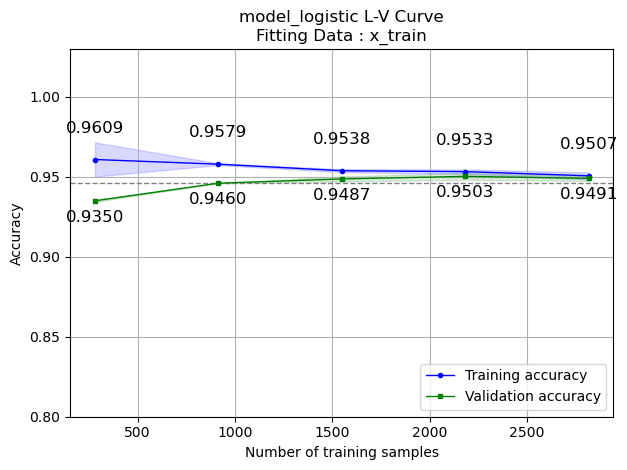

In [237]:
model_logistic = LogisticRegression()
acc_val_calc(model_logistic, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_logistic, x_train, y_train, x_test, y_test)


Model name : model_logistic
Fitting Data : x_train_over
acc : 0.9332860184528035 
val : 0.94417593040116


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


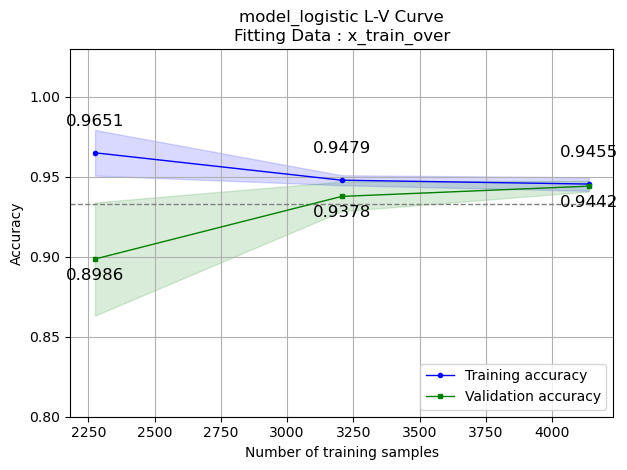

In [238]:
# Oversampling data
acc_val_calc(model_logistic, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_logistic, x_train_over, y_train_over, x_test, y_test)


### Modeling - SVM

Model name : model_svm
Fitting Data : x_train
acc : 0.9368346344925479 
val : 0.9403620873269436


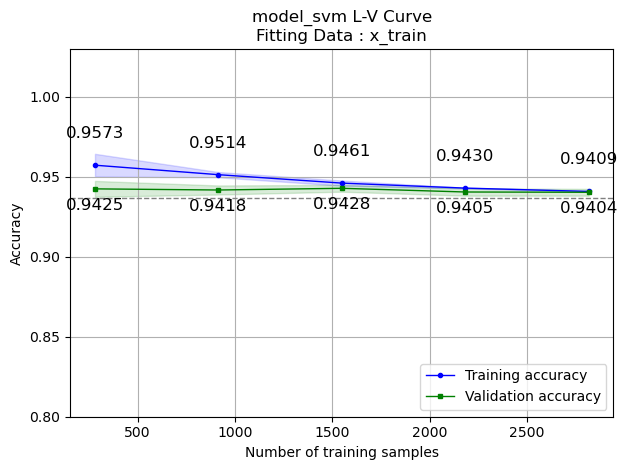

In [239]:
model_svm = svm.SVC(kernel='linear', C=1, probability=True)
acc_val_calc(model_svm, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_svm, x_train, y_train, x_test, y_test)

Model name : model_svm
Fitting Data : x_train_over
acc : 0.9318665720369056 
val : 0.944538424359594


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


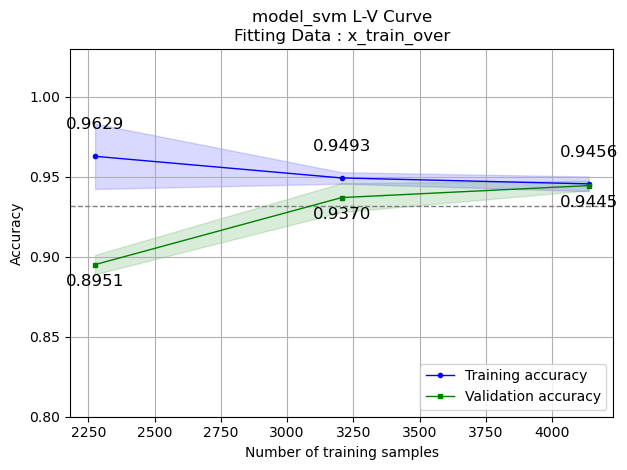

In [240]:
# Oversampling data
acc_val_calc(model_svm, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_svm, x_train_over, y_train_over, x_test, y_test)

Model name : model_svm_rbf
Fitting Data : x_train
acc : 0.9474804826117814 
val : 0.9506567270145545


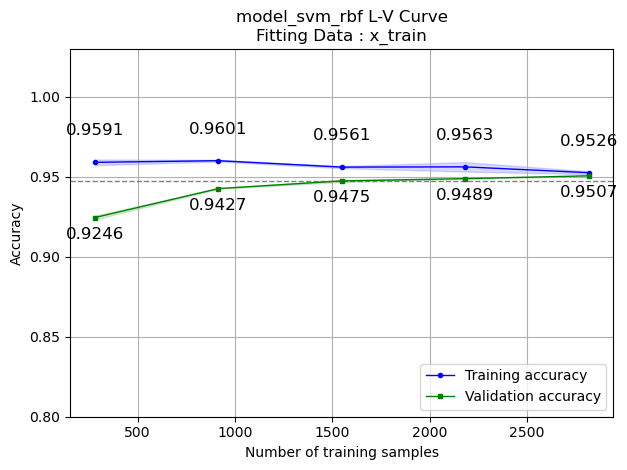

In [241]:
model_svm_rbf = svm.SVC(kernel='rbf', probability=True)
acc_val_calc(model_svm_rbf, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_svm_rbf, x_train, y_train, x_test, y_test)

Model name : model_svm_rbf
Fitting Data : x_train_over
acc : 0.9332860184528035 
val : 0.944296761720638


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


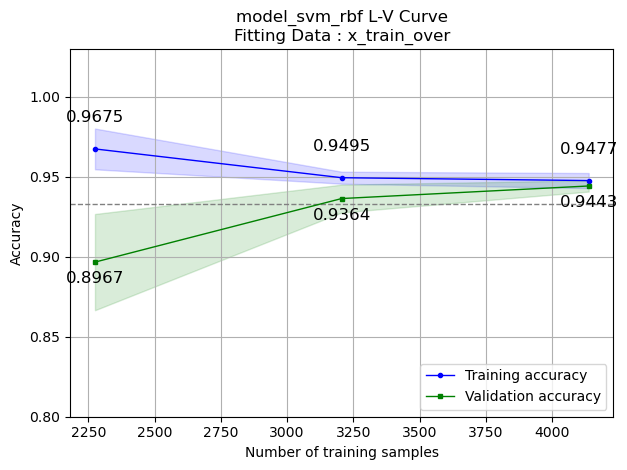

In [242]:
# Oversampling data
acc_val_calc(model_svm_rbf, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_svm_rbf, x_train_over, y_train_over, x_test, y_test)

### Modeling - Random Forest

Model name : model_rf
Fitting Data : x_train
acc : 0.9439318665720369 
val : 0.9552715654952078


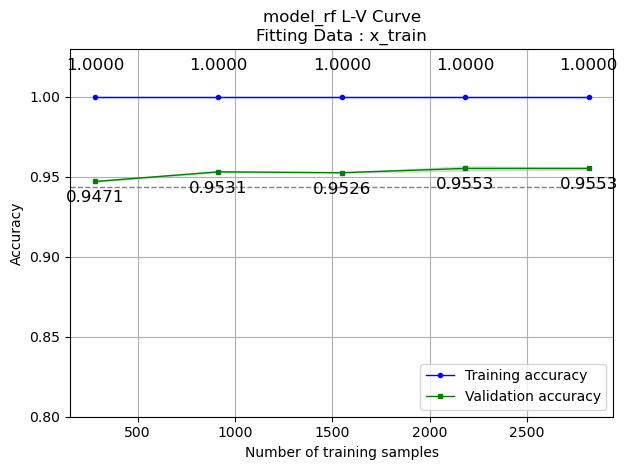

In [243]:
model_rf = RandomForestClassifier(random_state=100)
acc_val_calc(model_rf, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_rf, x_train, y_train, x_test, y_test)

Model name : model_rf
Fitting Data : x_train_over
acc : 0.9453513129879347 
val : 0.9609714838086032


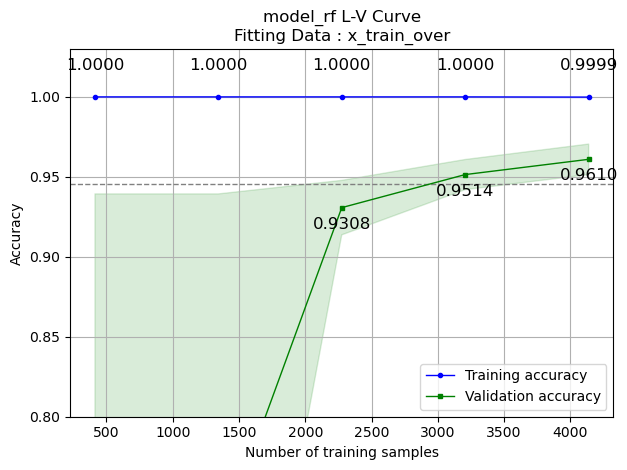

In [244]:
# Oversampling data
acc_val_calc(model_rf, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_rf, x_train_over, y_train_over, x_test, y_test)

### Modeling - DecisionTree

Model name : model_dt
Fitting Data : x_train
acc : 0.9325762952448545 
val : 0.9341498047568335


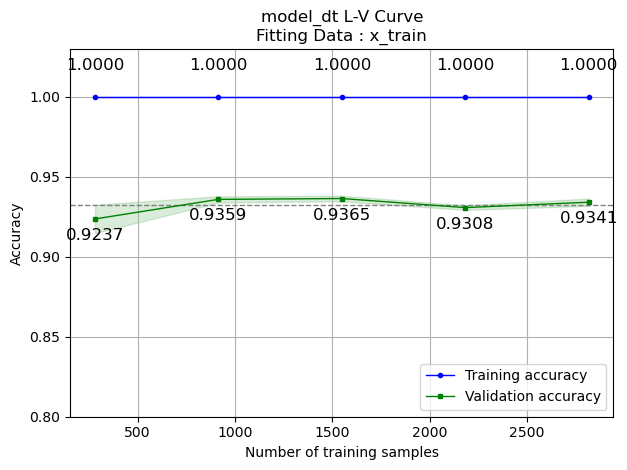

In [245]:
model_dt = DecisionTreeClassifier(random_state=100)
acc_val_calc(model_dt, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_dt, x_train, y_train, x_test, y_test)

Model name : model_dt
Fitting Data : x_train_over
acc : 0.9183818310858765 
val : 0.9422426292895119


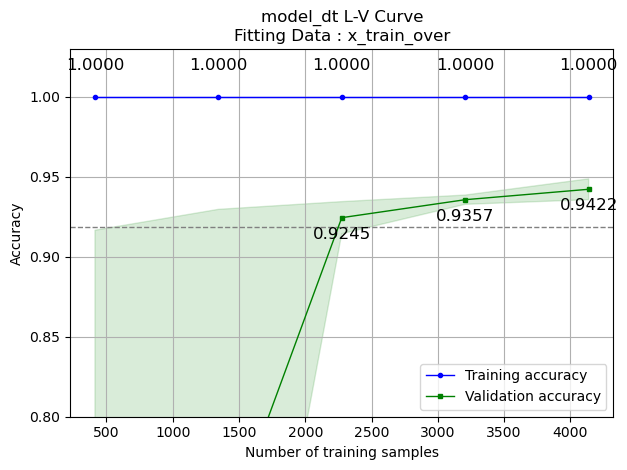

In [246]:
# Oversampling data
acc_val_calc(model_dt, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_dt, x_train_over, y_train_over, x_test, y_test)

### Modeling - KNN

Model name : model_kn
Fitting Data : x_train
acc : 0.9268985095812633 
val : 0.9235001774937877


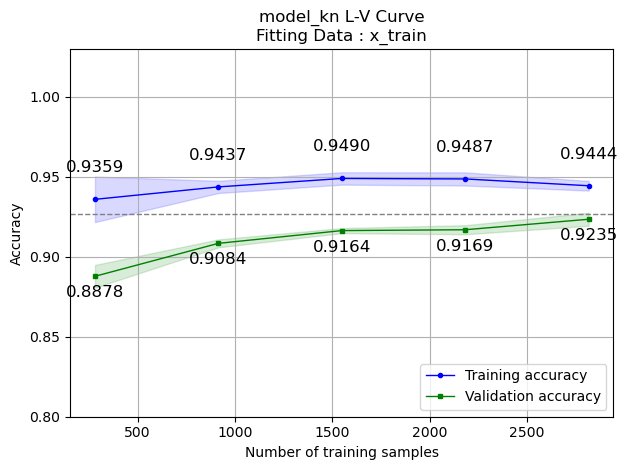

In [247]:
model_kn = KNeighborsClassifier()
acc_val_calc(model_kn, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_kn, x_train, y_train, x_test, y_test)

Model name : model_kn
Fitting Data : x_train_over
acc : 0.9127040454222853 
val : 0.9301594973417109


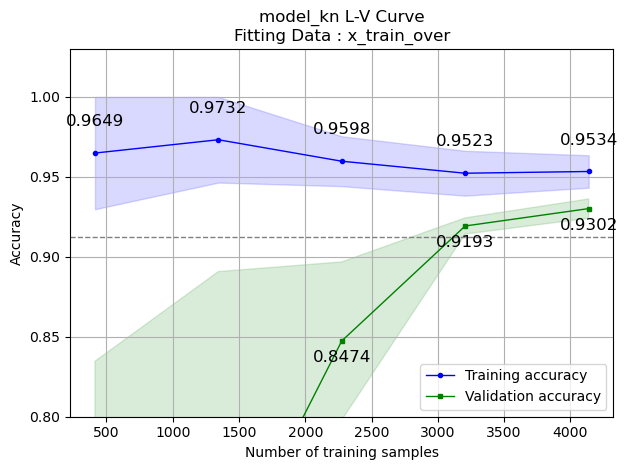

In [248]:
# Oversampling data
acc_val_calc(model_kn, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_kn, x_train_over, y_train_over, x_test, y_test)

### Modeling - Naive Bayes

Model name : model_nb
Fitting Data : x_train
acc : 0.8289567068843151 
val : 0.8299609513667021


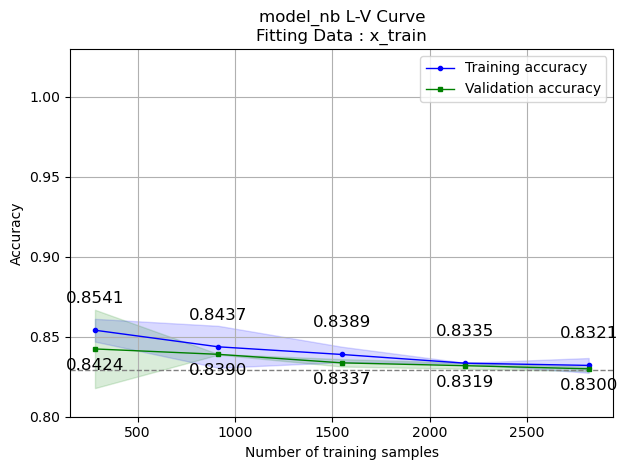

In [265]:
model_nb = GaussianNB()
acc_val_calc(model_nb, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_nb, x_train, y_train, x_test, y_test, 'upper right')

Model name : model_nb
Fitting Data : x_train_over
acc : 0.8254080908445706 
val : 0.8456984050265829


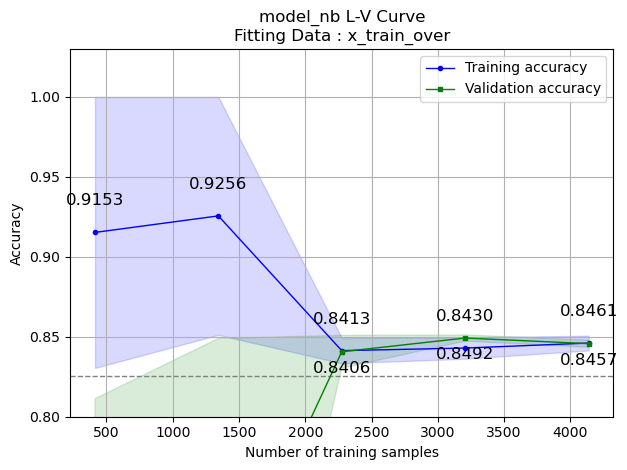

In [264]:
# Oversampling data
acc_val_calc(model_nb, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_nb, x_train_over, y_train_over, x_test, y_test, 'upper right')

### Modeling - GBT

Model name : model_gbt
Fitting Data : x_train
acc : 0.9474804826117814 
val : 0.9554490592829251


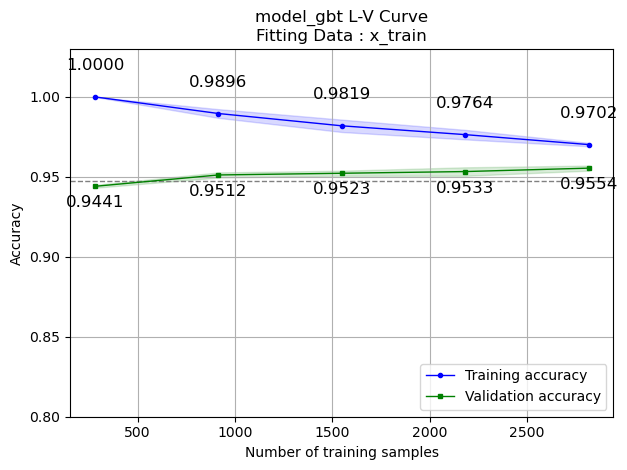

In [251]:
model_gbt = GradientBoostingClassifier(random_state=100)
acc_val_calc(model_gbt, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_gbt, x_train, y_train, x_test, y_test)

Model name : model_gbt
Fitting Data : x_train_over
acc : 0.9467707594038325 
val : 0.9497341710971483


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


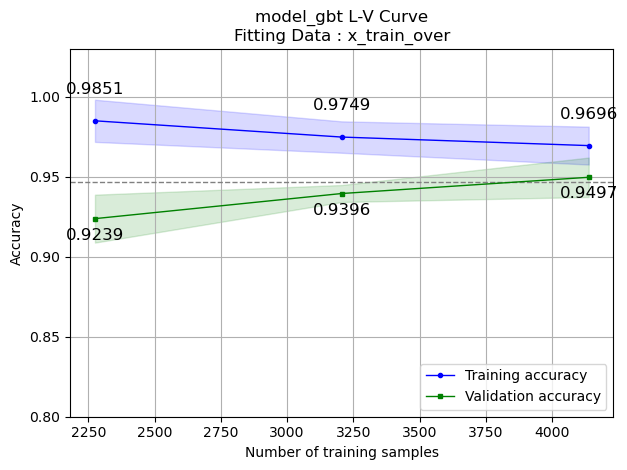

In [252]:
# Oversampling data
acc_val_calc(model_gbt, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_gbt, x_train_over, y_train_over, x_test, y_test)

### Modeling - SGD

Model name : model_sgd
Fitting Data : x_train
acc : 0.9403832505322924 
val : 0.9469293574724884


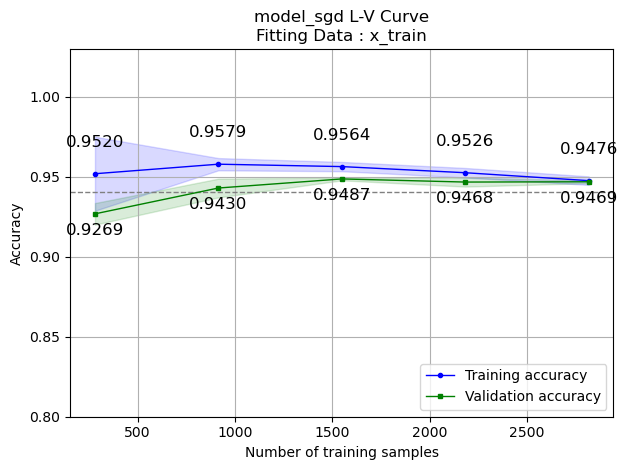

In [253]:
model_sgd = SGDClassifier(random_state=100)
acc_val_calc(model_sgd, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_sgd, x_train, y_train, x_test, y_test)

Model name : model_sgd
Fitting Data : x_train_over
acc : 0.943222143364088 
val : 0.9420009666505558


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


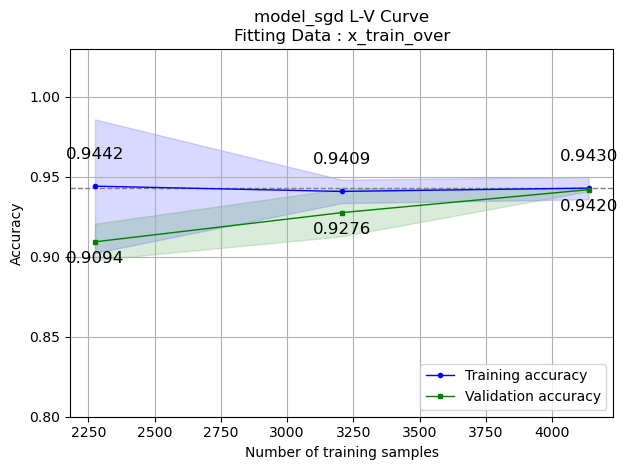

In [254]:
# Oversampling data
acc_val_calc(model_sgd, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_sgd, x_train_over, y_train_over, x_test, y_test)

### Modeling - Adaboost

Model name : model_ada
Fitting Data : x_train
acc : 0.9460610361958836 
val : 0.9510117145899893


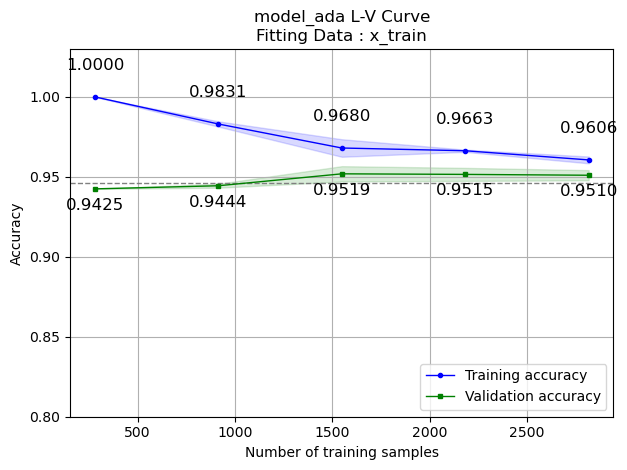

In [255]:
model_ada = AdaBoostClassifier(random_state=100)
acc_val_calc(model_ada, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_ada, x_train, y_train, x_test, y_test)

Model name : model_ada
Fitting Data : x_train_over
acc : 0.9425124201561391 
val : 0.9474383760270662


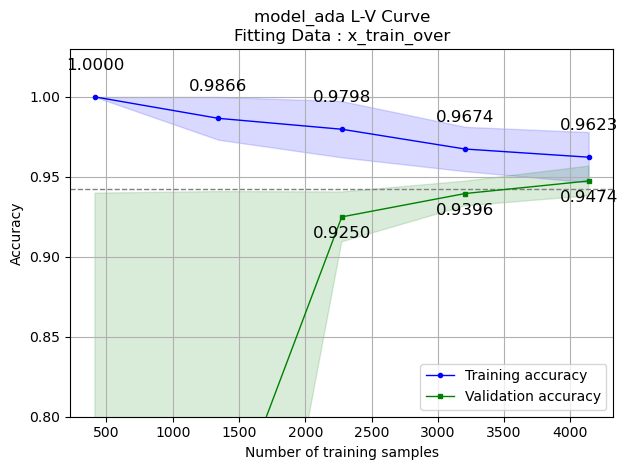

In [256]:
# Oversampling data
acc_val_calc(model_ada, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_ada, x_train_over, y_train_over, x_test, y_test)

### Modeling - LightGBM

Model name : model_lgbm
Fitting Data : x_train
acc : 0.9418026969481902 
val : 0.9547390841320553


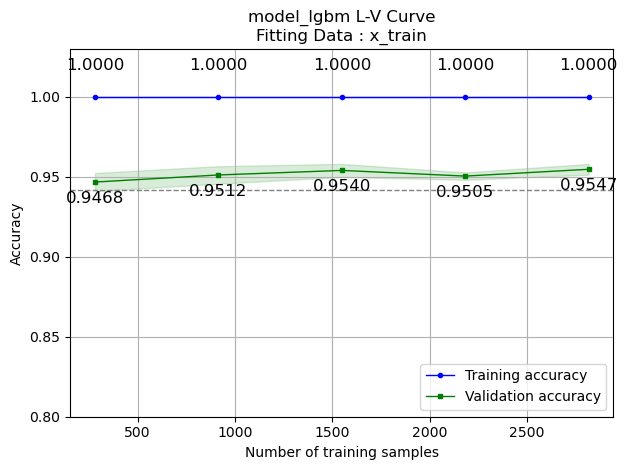

In [257]:
model_lgbm = LGBMClassifier(random_state=100)
acc_val_calc(model_lgbm, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_lgbm, x_train, y_train, x_test, y_test)

Model name : model_lgbm
Fitting Data : x_train_over
acc : 0.9425124201561391 
val : 0.9569840502658289


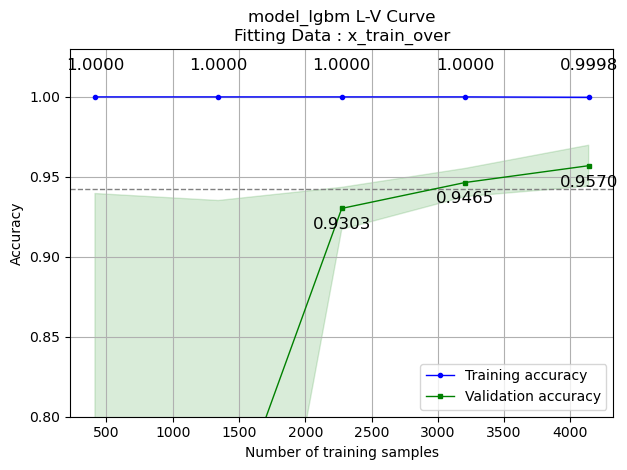

In [258]:
# Oversampling data
acc_val_calc(model_lgbm, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_lgbm, x_train_over, y_train_over, x_test, y_test)

### Modeling - XGBoost

Model name : model_xgb
Fitting Data : x_train
acc : 0.9410929737402413 
val : 0.9515441959531417


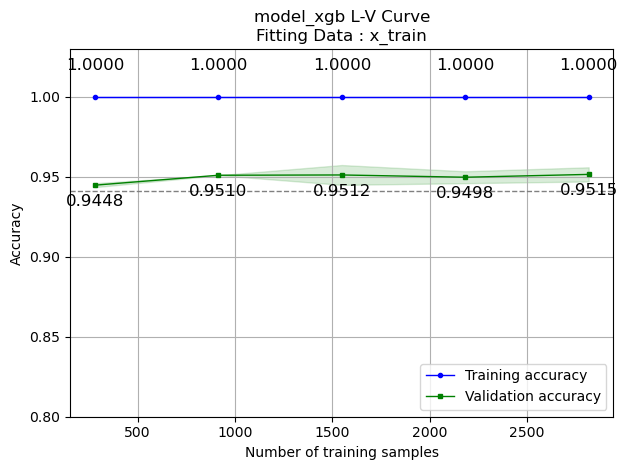

In [259]:
model_xgb = XGBClassifier(random_state=100)
acc_val_calc(model_xgb, x_train, y_train, x_test, y_test)
learn_valid_curve_plot(model_xgb, x_train, y_train, x_test, y_test)

Model name : model_xgb
Fitting Data : x_train_over
acc : 0.9396735273243435 
val : 0.9573465442242629


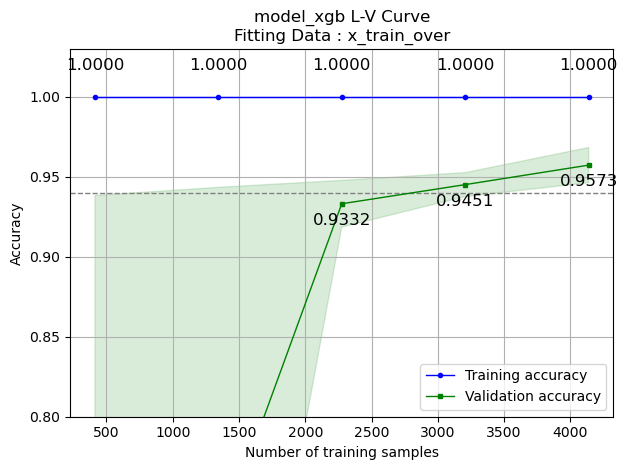

In [260]:
# Oversampling data
acc_val_calc(model_xgb, x_train_over, y_train_over, x_test, y_test)
learn_valid_curve_plot(model_xgb, x_train_over, y_train_over, x_test, y_test)

### One-page plot

In [261]:
def learn_vali_plot(axes, rows, cols, datas_num):
    models = [[model_logistic,model_logistic,model_svm,model_svm],
    [model_svm_rbf,model_svm_rbf,model_rf,model_rf],
    [model_dt,model_dt,model_kn,model_kn],
    [model_nb,model_nb,model_gbt,model_gbt],
    [model_sgd,model_sgd,model_ada,model_ada],
    [model_lgbm,model_lgbm,model_xgb,model_xgb]]
    
    models_name = [['model_logistic','model_logistic','model_svm','model_svm'],
    ['model_svm_rbf','model_svm_rbf','model_rf','model_rf'],
    ['model_dt','model_dt','model_kn','model_kn'],
    ['model_nb','model_nb','model_gbt','model_gbt'],
    ['model_sgd','model_sgd','model_ada','model_ada'],
    ['model_lgbm','model_lgbm','model_xgb','model_xgb']]

    datas = [[x_train, y_train], [x_train_over, y_train_over]]
    
    datas_name = [['x_train', 'y_train'], ['x_train_over', 'y_train_over']]

    train_sizes, train_scores, test_scores = learning_curve(estimator=models[rows][cols], X=datas[datas_num][0], y=datas[datas_num][1], cv=2, n_jobs=1)

    predict_result = model_xgb.predict(x_test)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    axes[rows, cols].plot(train_sizes, train_mean, color='blue', marker='o', markersize=3, label='Training accuracy', linewidth=1)
    axes[rows, cols].fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    axes[rows, cols].plot(train_sizes, test_mean, color='green', marker='s', markersize=3, label='Validation accuracy', linewidth=1)
    axes[rows, cols].fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

    axes[rows, cols].grid()

    if datas_name[datas_num][0] == 'x_train':
        axes[rows, cols].set_title(models_name[rows][cols])
    else:
        axes[rows, cols].set_title(models_name[rows][cols]+'_Oversampling')

    # axes[rows, cols].legend(loc='lower right')
    # axes[rows, cols].ylim([0.8, 1.03])
    # axes[rows, cols].tight_layout()


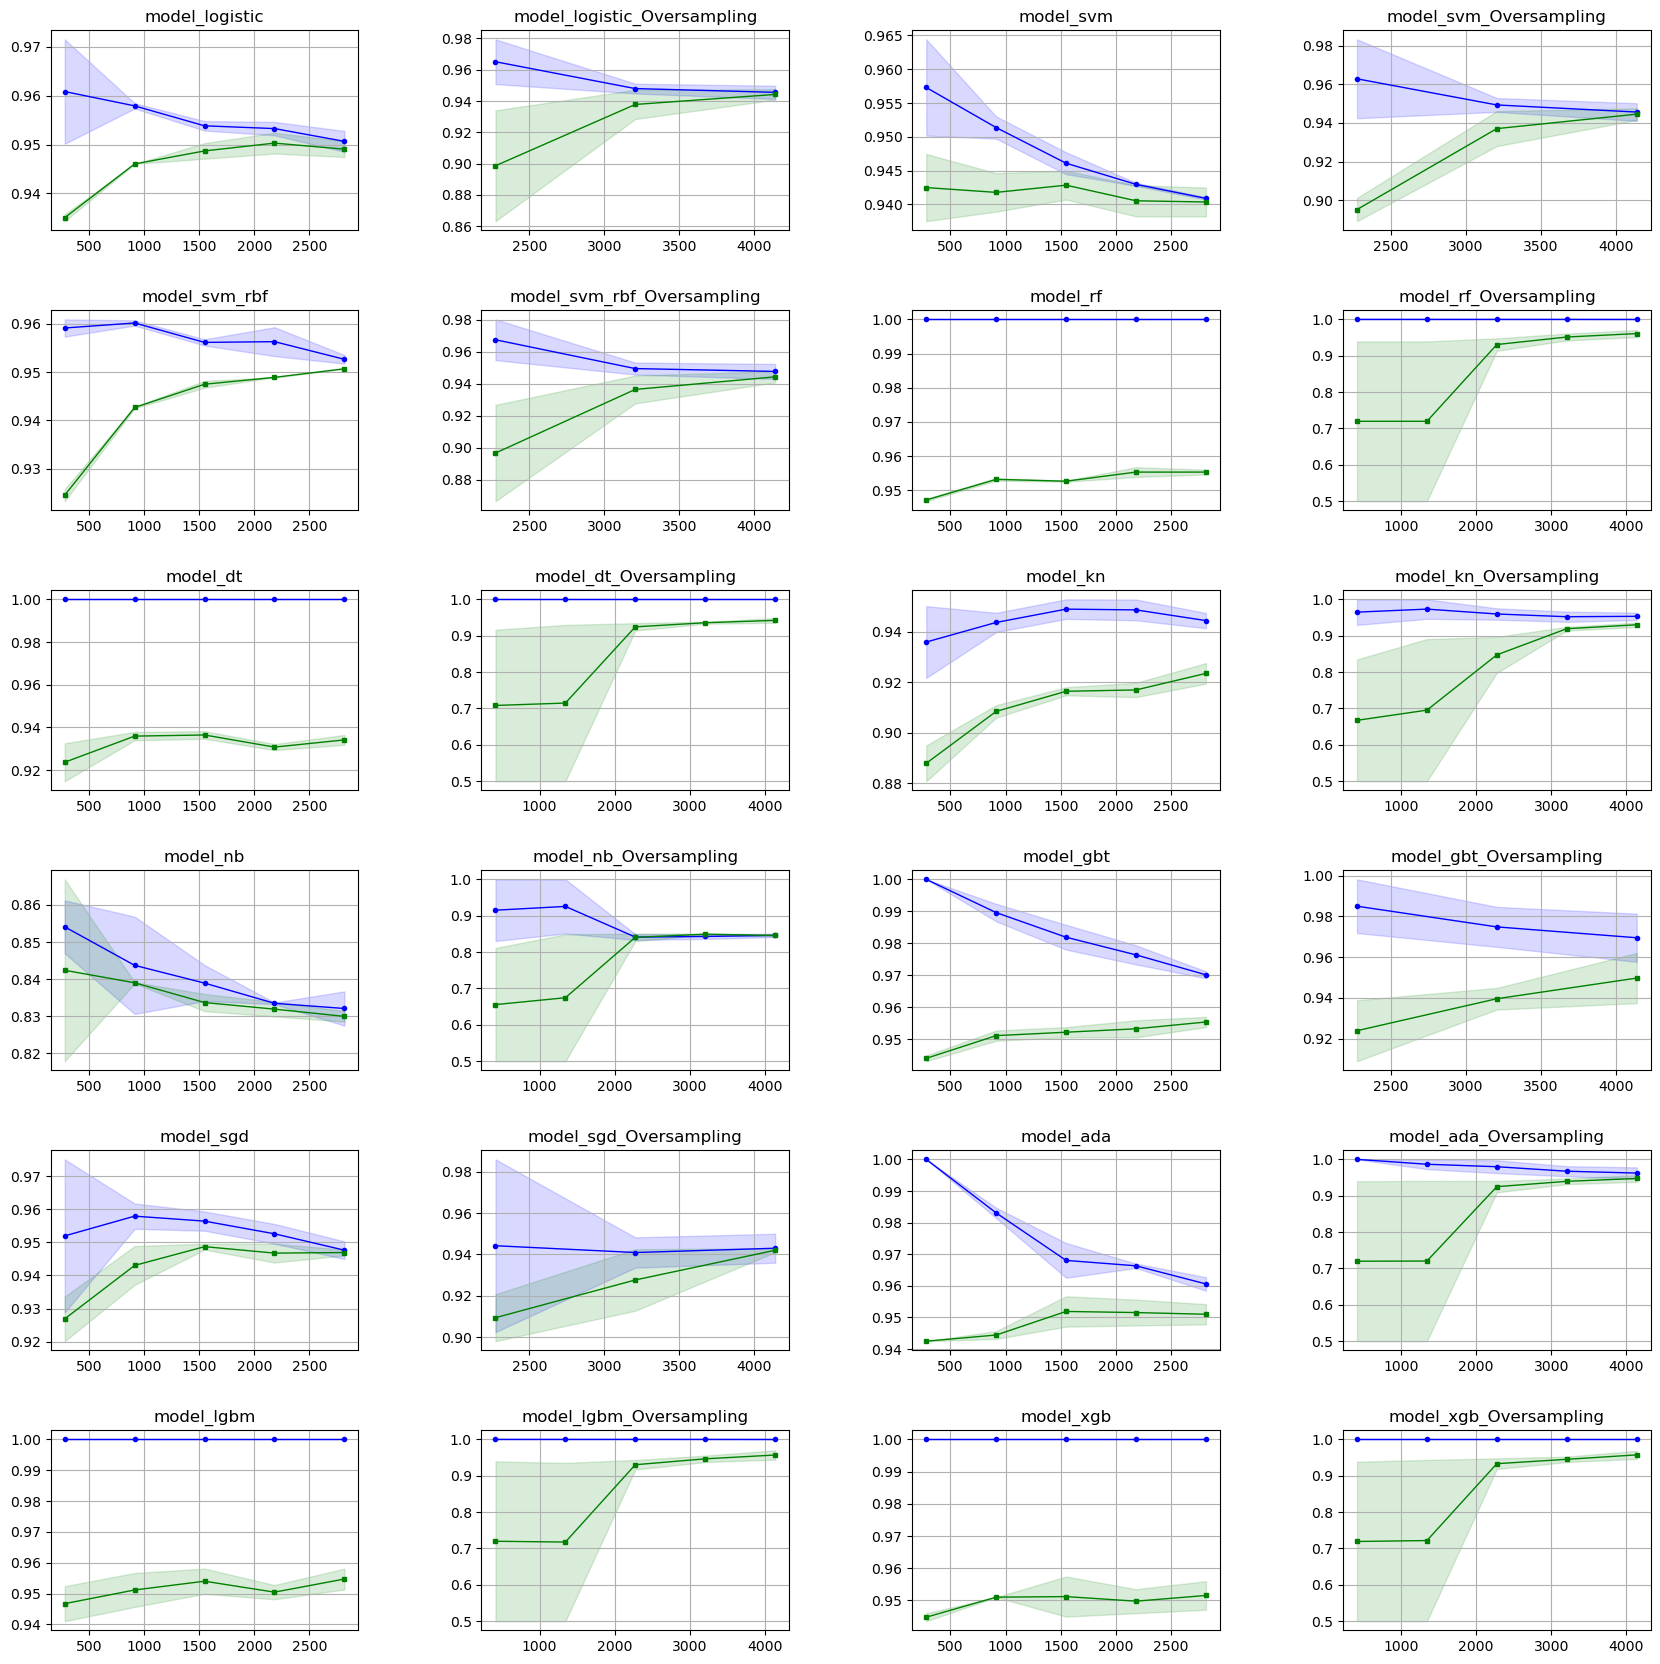

In [262]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i in range(6):
    for j, k in zip(range(4), [0,1,0,1]):
        # print(i, j, k)
        learn_vali_plot(ax, i, j, k)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.show()